In [29]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 

exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_evaluate_pose_estimation.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

batch = dataset_train[13450][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render,h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask,  bb = batch[24:]

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
        
    def disp_img_1d(self,img,hold=False, save=False, nr=0):
        self.data.append(img)
        p = '/home/jonfrey/Debug/Midterm2/'
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Reds' )
                fig.colorbar(pos, ax=ax[-1])
            plt.show()
            if save:
                fig.savefig(p+str(nr)+'.png', dpi=300)
                
            self.data = []
            self.ax = []
    

h = 480
w = 640

from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw


Finished loading meshes 0.3784184455871582


In [96]:
desig = unique_desig[0]
_p_ycb = "/media/scratch1/jonfrey/datasets/YCB_Video_Dataset"
depth = np.array(Image.open(
    '{0}/{1}-depth.png'.format(_p_ycb, desig)))
depth.shape

label = np.array(Image.open(
    '{0}/{1}-label.png'.format(_p_ycb, desig)))

torch.Size([480, 640, 3])
tensor(0.)


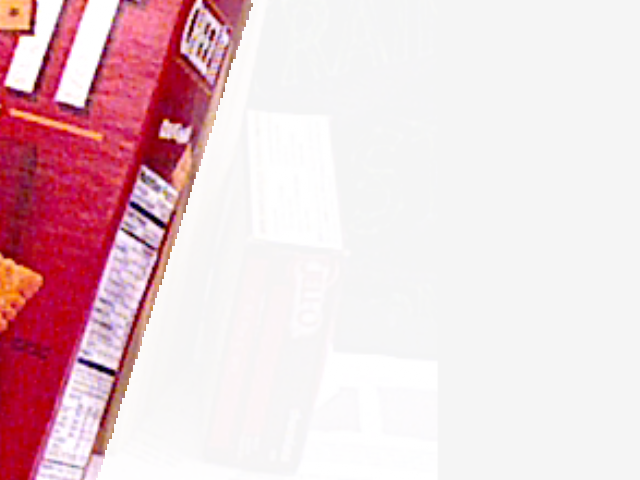

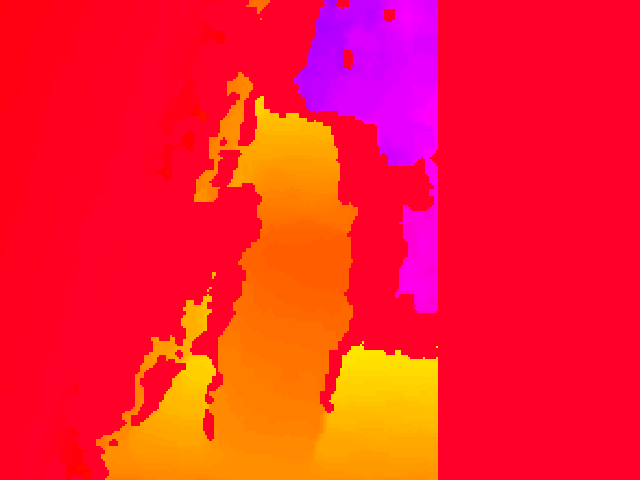

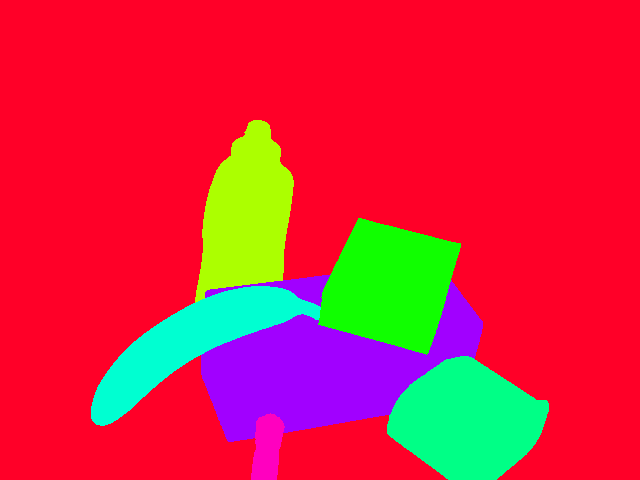

In [30]:
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]

def disp_alignment(depth, label, real):
    data = np.zeros((480,640,4), dtype=np.uint8)
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    t = real.permute(1,2,0)
    print(t.shape)
    data[:,:,:3] = t.numpy() # red patch in upper left
    data_depth[:,:,:3] = t.numpy()
    data[:,:,3] = 10
    
#     idx = np.uint8(label==2) *255
    data[:,:,3][label==2] = 255
    
    min_val = torch.min( depth[depth!=0] )
    max_val = torch.max( depth[depth!=0] )
    val = torch.clamp( (depth-min_val) / (max_val-min_val)*255 ,0,255)
    print( torch.min( val ) )

     


    img = Image.fromarray(data, 'RGBA')
    display(img)
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    data_depth[:,:,3] = 255
#     print(val.shape)
    for i in range(480):
        for j in range(640):
#             print(int( val[i,j]),  cmaplist[ int(val[i,j])])
            data_depth[i,j,:4] = np.array( cmaplist[ int(val[i,j])] )*255
    data_depth[:,:,3] = 255
    data_depth[:,:,3][label==2] = 255
    img_depth = Image.fromarray(data_depth, 'RGBA')
    display(img_depth)

disp_alignment(real_d[0], gt_label_cropped, real_img)
#disp_alignment(torch.tensor(depth, dtype=torch.float32), gt_label_cropped, real_img)
def plot(mask):
    min_val = torch.min( mask )
    max_val = float( max(1,torch.max( mask )) )
    mask = torch.clamp( (mask-min_val) / (max_val-min_val)*255 ,0,255)
    
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    data_depth[:,:,3] = 255
#     print(val.shape)
    for i in range(480):
        for j in range(640):
#             print(int( val[i,j]),  cmaplist[ int(val[i,j])])
            data_depth[i,j,:4] = np.array( cmaplist[ int(mask[i,j])] )*255
    data_depth[:,:,3] = 255
    data_depth[:,:,3][label==2] = 255
    img_depth = Image.fromarray(data_depth, 'RGBA')
    display(img_depth)
plot(torch.tensor(label))

# disp_alignment(torch.tensor(label, dtype=torch.float32), gt_label_cropped, real_img)

In [20]:
from deep_im import LossAddS
import copy
from deep_im import flow_to_trafo

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

device = 'cuda'
exp['loader']['batch_size'] = 1
exp['loader']['pin_memory'] = False
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                                       **exp['loader'])

criterion_adds = LossAddS(sym_list=exp['d_train']['obj_list_sym'])

Finished loading meshes 0.3869962692260742


In [21]:
# Robustness analysis: 
# Load Sample
# Predict Pose
# Calculate ADD-S
# Store array containing UniqueDesig + ADD-S Value

# Try out what happens if flow dilatation is used. 
# Maybe the normal filtering aswell. 
# Check if there is some higher error for other objects

device = 'cpu'

desig_ls= []
adds_gt_ls = []
adds_init_ls = []

K_ren = torch.tensor( dataset_train._backend.get_camera('data_syn/0019', K=True), device=device )
for j,batch in enumerate(dataloader_train):
    if j > 50:
        break
    batch = batch[0] #bann 10450   
    model_points = batch[4]
    idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
    real_img_original = batch[8]
    cam = batch[9]
    gt_rot_wxyz, gt_trans, unique_desig = batch[10:13] # unique_desig[1] contains the idx starting at 1 for the first object 

    log_scalars = {}
    bs = model_points.shape[0]

    # check if skip
    if batch[13] is False:
        print('Continue')
        continue

    real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
    pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
    u_map, v_map, flow_mask, bb = batch[24:]
    data = torch.cat([real_img, render_img], dim=1)

    # TODO idx is currently unused !!!!

#     flow, p_label = self.pixelwise_refiner(
#         data, idx)

#     focal_loss = self.criterion_focal(
#         p_label, gt_label_cropped)

    ind = (flow_mask == True )[:,None,:,:].repeat(1,2,1,1)
    uv_gt = torch.stack( [u_map, v_map], dim=3 ).permute(0,3,1,2)
    
#     flow_loss = torch.sum( torch.norm( flow[:,:2,:,:] * ind  - uv_gt * ind, dim=1 ), dim=(1,2)) / torch.sum( ind[:,0,:,:], (1,2))

    real_tl, real_br, ren_tl, ren_br = bb 

    b = 0
    K_real = torch.tensor( [[cam[b,2],0,cam[b,0]],[b,cam[b,3],cam[b,1]],[0,0,1]], device=device )

    h_real_est = torch.eye(4,device=device)
    h_real_est[:3,:3] = quat_to_rot(pred_rot_wxyz[b][None,:], conv='wxyz', device=device)
    h_real_est[:3,3] = torch.tensor( pred_trans[b] ,device=device )

    typ = u_map.dtype

    P_real_in_center, P_ren_in_center, P_real_trafo, T_res = flow_to_trafo(real_br[b], 
        copy.deepcopy(real_tl[b]), 
        copy.deepcopy(ren_br[b]), 
        copy.deepcopy(ren_tl[b]), 
        copy.deepcopy(flow_mask[b]), 
        copy.deepcopy(u_map[b].type( typ )), 
        copy.deepcopy(v_map[b].type( typ )), 
        copy.deepcopy(K_real.type( typ )), 
        copy.deepcopy(K_ren.type( typ )), 
        copy.deepcopy(real_d[b][0].type( typ )), 
        copy.deepcopy(render_d[b][0].type( typ )), 
        copy.deepcopy(h_real_est.type( typ )), 
        copy.deepcopy(h_render[b].type( typ )))


    h_real_new_est =  T_res @ h_render[0].type(typ) # set rotation
    
#     typ = flow[b, 0, :, :].dtype
#     P_real_in_center, P_ren_in_center, P_real_trafo, T_res = flow_to_trafo(real_br[b], 
#         real_tl[b],
#         ren_br[b], 
#         ren_tl[b], 
#         flow_mask[b], 
#         flow[b, 0, :, :].type( typ ), 
#         flow[b, 1, :, :].type( typ ), 
#         K_real.type( typ ), 
#         K_ren.type( typ ), 
#         real_d[b][0].type( typ ), 
#         render_d[b][0].type( typ ), 
#         h_real_est.type( typ ), 
#         h_render[b].type( typ ))
#     h_real_new_est_pred_flow =  T_res @ h_render[0] # set rotation

    mask = (flow_mask == True)
    p = model_points.shape[1]

    target = torch.bmm( model_points, torch.transpose(h_real[:,:3,:3], 1,2 ) ) + h_real[:,:3,3][:,None,:].repeat(1,p,1)
    # Compute ADD-S
    adds_res_gt_flow = criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = h_real_new_est[None].type( target.dtype) )
    
    #adds_res_pred_flow = self.criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = h_real_new_est_pred_flow[None].type( target.dtype))
    adds_init = criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = h_real_est[None].type( target.dtype))

    # adds_gt = self.criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = h_real[0][None])
    # log scalars            
    #log_scalars[f'adds_init'] = float(adds_init.detach())
    print( float(adds_res_gt_flow.detach()), float(adds_init.detach()))
#   log_scalars[f'adds_res_gt_flow'] = float(adds_res_gt_flow.detach())
#   log_scalars[f'adds_res_pred_flow'] = float(adds_res_pred_flow.detach())

    desig_ls.append(unique_desig)
    adds_gt_ls.append(float(adds_res_gt_flow.detach()))
    adds_init_ls.append(float(adds_init.detach()))




/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.0034156518522650003 0.038752295076847076
0.029933299869298935 0.04116480425000191
0.01217199768871069 0.04335184022784233
0.01227189227938652 0.050329796969890594
0.0017888230504468083 0.026736019179224968
0.003131165402010083 0.03417491912841797
0.00445918133482337 0.029443485662341118
0.0029259738512337208 0.03379770368337631
0.002090052468702197 0.02111770398914814
0.007082423195242882 0.042119596153497696
0.030682777985930443 0.07332679629325867
0.002229878446087241 0.030778612941503525
0.0055479444563388824 0.02235955372452736
0.003581981174647808 0.022588759660720825
0.023454194888472557 0.04844118654727936
0.0030527531635016203 0.009866256266832352
0.017321890220046043 0.028083236888051033
0.007178122643381357 0.04720132425427437
0.013278836384415627 0.0315655954182148
0.0057828715071082115 0.039510924369096756
0.030137361958622932 0.03529713675379753
0.0022458056919276714 0.05158260837197304
0.028947269544005394 0.03276800736784935
0.0069694011472165585 0.020212456583976746
0

In [32]:
import matplotlib.pyplot as plt
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]

def plot(mask):
    min_val = torch.min( mask )
    max_val = float( max(1,torch.max( mask )) )
    mask = torch.clamp( (mask-min_val) / (max_val-min_val)*255 ,0,255)
    
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    data_depth[:,:,3] = 255
#     print(val.shape)
    for i in range(480):
        for j in range(640):
#             print(int( val[i,j]),  cmaplist[ int(val[i,j])])
            data_depth[i,j,:4] = np.array( cmaplist[ int(mask[i,j])] )*255
    data_depth[:,:,3] = 255
    data_depth[:,:,3][label==2] = 255
    img_depth = Image.fromarray(data_depth, 'RGBA')
    display(img_depth)

[('data/0002/000546',), tensor([10], dtype=torch.int32)]
data/0002/000546 10


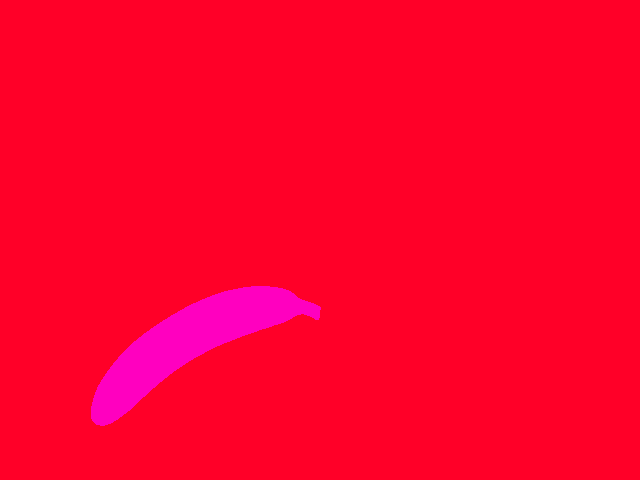

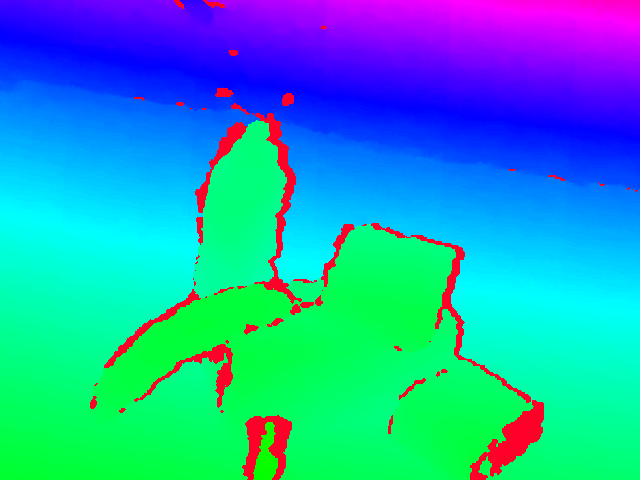

[('data/0003/001992',), tensor([8], dtype=torch.int32)]
data/0003/001992 8


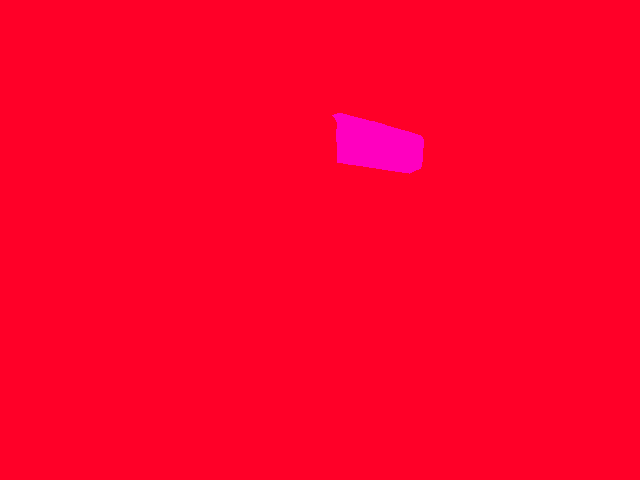

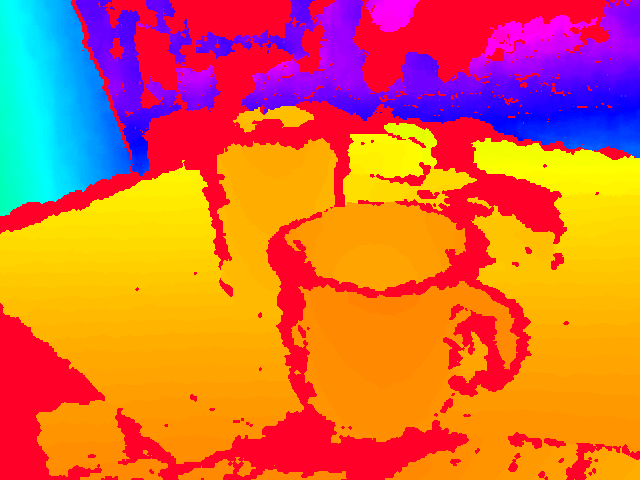

[('data/0008/002976',), tensor([5], dtype=torch.int32)]
data/0008/002976 5


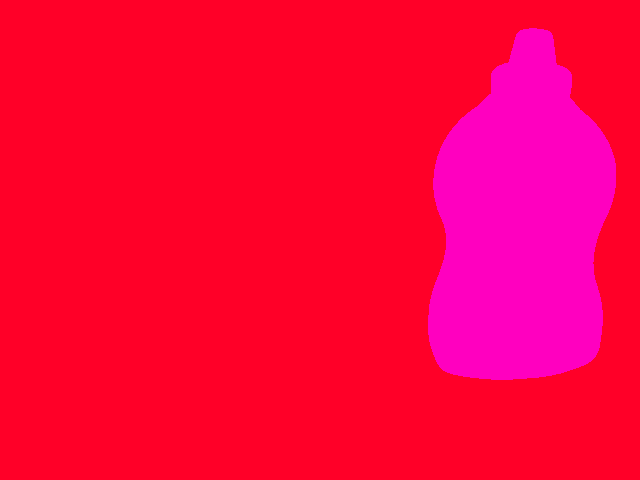

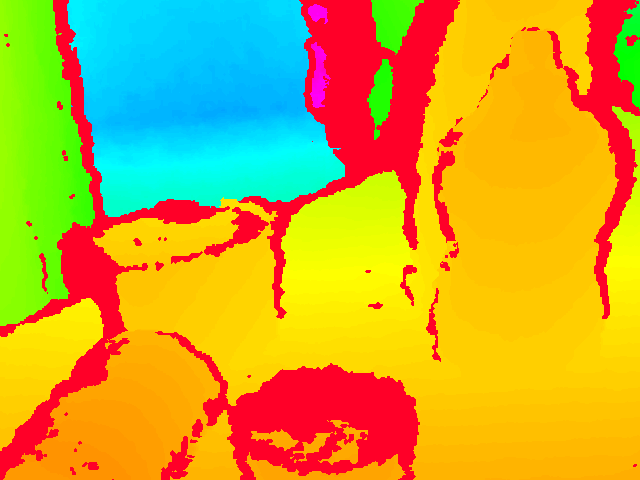

[('data/0008/002576',), tensor([5], dtype=torch.int32)]
data/0008/002576 5


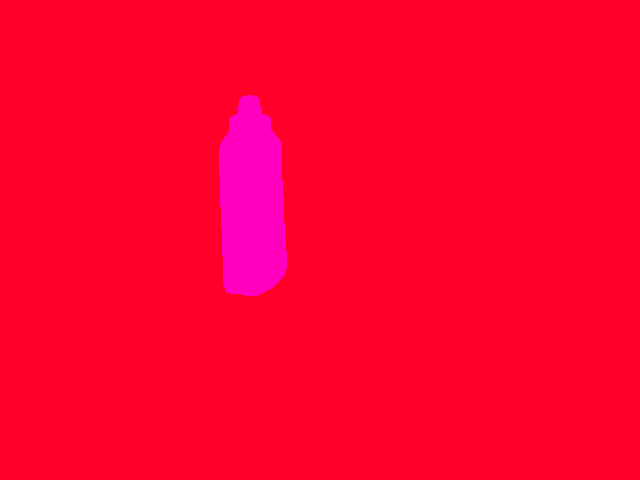

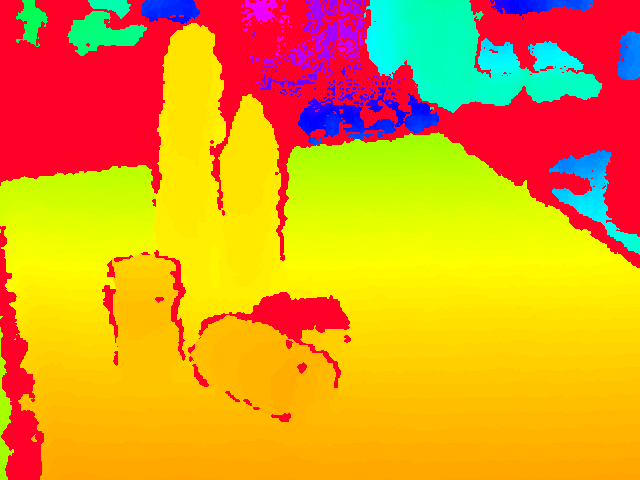

[('data/0003/001992',), tensor([8], dtype=torch.int32)]
data/0003/001992 8


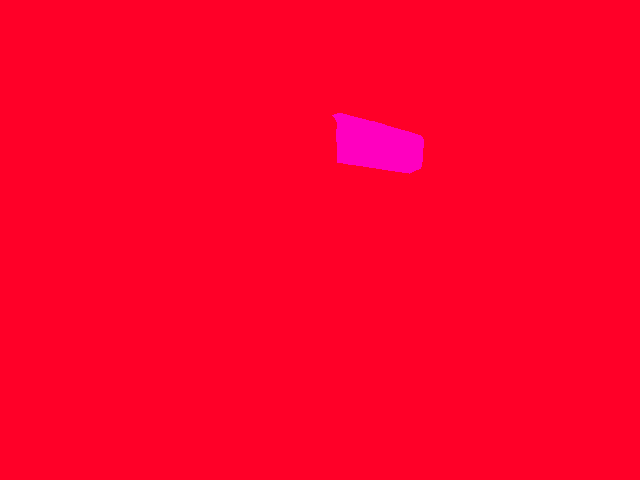

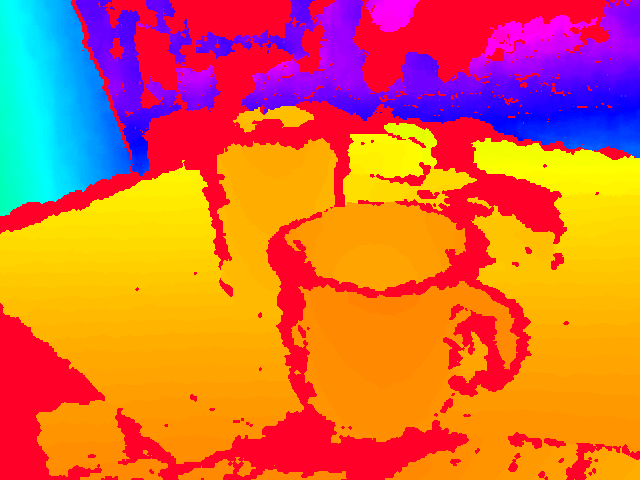

[('data/0006/001214',), tensor([15], dtype=torch.int32)]
data/0006/001214 15


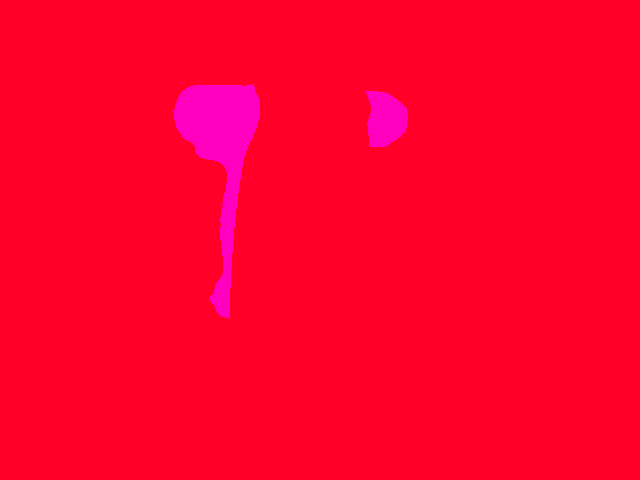

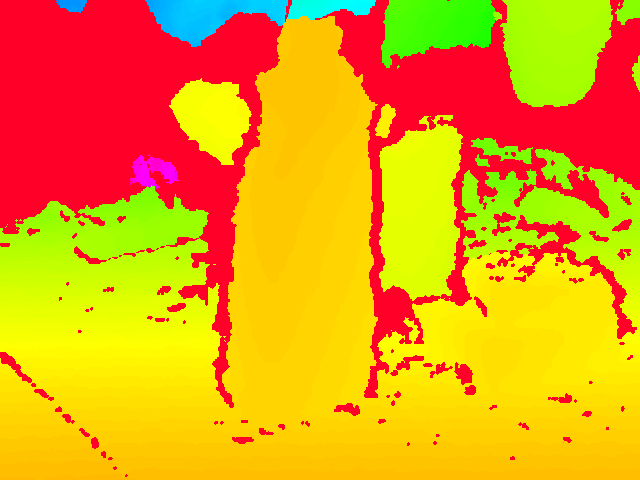

In [39]:
for j,i in enumerate( adds_gt_ls ):
    if i > 0.03:
        print(desig_ls[j])
        desig = desig_ls[j][0][0]
        print(desig, int(desig_ls[j][1]))
        _p_ycb = "/media/scratch1/jonfrey/datasets/YCB_Video_Dataset"
        depth = np.array(Image.open(
            '{0}/{1}-depth.png'.format(_p_ycb, desig)))
        label = np.array(Image.open(
            '{0}/{1}-label.png'.format(_p_ycb, desig)))
        labseg = torch.tensor(label)
        
        labseg[torch.tensor(label) != int(desig_ls[j][1])] = 0
        plot( labseg)
        #plot(torch.tensor(label) )
        plot(torch.tensor(depth) )